In [95]:
#install package for spotify api (spotipy)
#documentation: https://spotipy.readthedocs.io/en/2.9.0/
# import pip._internal as pip
# package_name=['spotipy'] #package to install
# pip.main(['install'] + package_name + ['--upgrade']) 

In [2]:
#loading all needed packages
import spotipy
import spotipy.util
import sys
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

In [3]:
#spotify authorization: code from spotipy documentation
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id='e9eba946c668460e897d046a8a100e47', client_secret='8b624ef3fbcc40ad8168fb7eb04f7bfc')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

### Pulling Song URI's from Two Albums

First get uri for the artist, then uri for the two albums you want to compare, then each song in each album. 
Here we assume we are only comparing albums from the same artist

#### Getting artist uri

In [4]:
#code from bonnarhythms, just for one artist
artist_names = ['the 1975']
artists = {}

for name in artist_names:
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    try:
        artists[items[0]['name']] = items[0]['id'] # add key-value pair of each artist name and their spotify ID
    except:
        print(name)  

#### Getting individual song uris

In [5]:
for value in artists:
    albums = [] 
    trackid = []
    results = sp.artist_albums(artists[value], album_type='album')
    albums.extend(results['items'])
    while results['next']:
        results = sp.next(results)
        albums.extend(results['items'])
    unique = set()  # skip duplicate albums
    print('Choose two to compare: ')
    for album in albums:
        name = album['name']
        if name not in unique: #adds non-duplicates to unique set
            print(name)
            unique.add(name)
            tracks = []
            
            results = sp.album_tracks(album['id'])
            tracks.extend(results['items'])
            while results['next']:
                results = sp.next(results)
                tracks.extend(results['items'])
            for track in tracks: 
                trackid.append([album['name'], track['name'],track['uri']]) #creates a list of lists 
    df = pd.DataFrame(trackid, columns =['AlbumName', 'TrackName', 'uri'])  #makes list of lists into a dataframe
    

Choose two to compare: 
A Brief Inquiry Into Online Relationships
DH00278 (Live)
DH00278 (Live from The O2, London. 16.12.16)
I like it when you sleep, for you are so beautiful yet so unaware of it
The 1975
The 1975 (Deluxe)
The 1975 (Deluxe Version)
The 1975 (Deluxe Edition)
Sex


#### Subsetting data to two selected comparisons
user must put manually input the two albums they want to compare

In [6]:
#function to subset data based on two selected albums
def subset_album_compare(album1,album2):
    global uris #make this global so we can use outside the function
    global comparisondf
    global album_1 #global for use in encoding target variable later
    global album_2
    
    comparisondf = df[(df['AlbumName'] == album1) | (df['AlbumName'] == album2)] #new dataframe
    uris = comparisondf['uri'].tolist() #list of only uri's for pulling features and analysis  
    album_1 = album1
    album_2 = album2

In [7]:
#user decides which two albums to compare, this is case sensitive so copy paste from above options
subset_album_compare('The 1975', 'A Brief Inquiry Into Online Relationships')

### Pulling and narrowing down features

#### Getting audio features

In [15]:
features=pd.DataFrame()
features=pd.DataFrame(sp.audio_features(uris)) #load into dataframe
song_features = pd.merge(comparisondf, features, on='uri') #merge features with main comparisondf dataframe

#### Formatting target var and categorical features to be numeric

In [20]:
#removed mode for this specific case because it gives very little added info, removed uri and track name bc not relevant for analysis
song_features = song_features[['AlbumName','acousticness','danceability','duration_ms','energy','instrumentalness','key','liveness','loudness','speechiness','tempo','time_signature','valence']]

#one-hot encode categorical object: time signature
song_features_encoded=pd.get_dummies(song_features, columns=["time_signature"])

#change album name to binary: 0 is a brief inquiry, 1 is the 1975
song_features_encoded["album"] = np.where(song_features["AlbumName"].str.contains(album_1), 1, 0)

#drop album name
song_features_encoded=song_features_encoded.drop(['AlbumName'], axis=1).astype(np.float64)

#export to csv
song_features_encoded.to_csv(r'C:\Users\Liesl\Desktop\Resumes\Untitled Folder\song_features_encoded.csv')

#### Use PCA to analyze current features: only

code pulled from here: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

In [10]:
#standardize the data
from sklearn.preprocessing import StandardScaler
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key','liveness','loudness','speechiness','tempo','valence', \
           'time_signature_3', 'time_signature_4'] #must manually change time signature variables based on what is in the data, all other vars remain the same regardless of artist/album

# Separating out the features
x = song_features_encoded.loc[:, features].values
# Separating out the target
y = song_features_encoded.loc[:,['album']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [11]:
#get pca analysis
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

#final dataframe
finalDf = pd.concat([principalDf, song_features_encoded[['album']]], axis = 1)

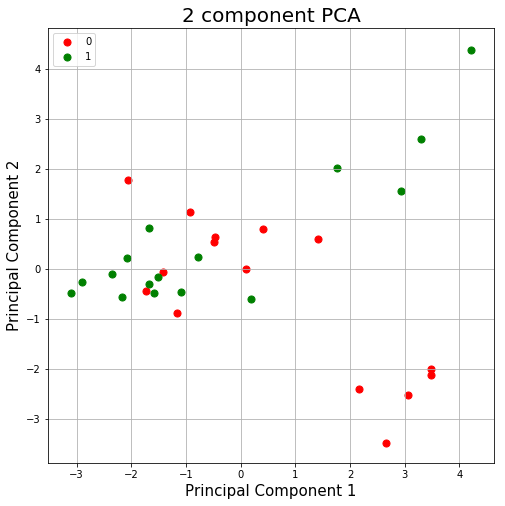

In [12]:
#plot first two principle components
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['album'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [13]:
#get percent of variance explained by first two components
pca.explained_variance_ratio_

array([0.35899984, 0.18484605])

### TRANSFER TO R: 

In [ ]:
# library(tidyverse)
# library(glmnet)
# library(car)

# #load data in
# features <- read.csv('C:/Users/Liesl/Desktop/Resumes/Untitled Folder/song_features_encoded.csv')

# #TEST THROUGH FULL VARIABLE SET
# #subset into features and target var. note if you choose a new artist you may have to change column ## based on how many time sig values you have
# x <- as.matrix(features[,-c(1,15)]) #include all variables (except row# and target)
# y <- features[,15] #target

# #finding optimal value of lambda
# cv.lasso <- cv.glmnet(x, y, alpha = 1, family = "binomial")
# cv.lasso$lambda.min
# cv.lasso$lambda.1se

# #view coefficients of variables
# coef(cv.lasso,cv.lasso$lambda.min)
# coef(cv.lasso,cv.lasso$lambda.1se)
# #RESULT: both min and 1se keep: acousticness, duration_ms, energy, liveness, loudness, tempo, time signatures

# #keep only the vars that the lasso kept, remove second ts as it is redundant info (what is 0 in ts3 is 1 in ts4)
# x.lasso <- as.matrix(features[,c(2,4,5,8,9,11,13)])
# #get new lambdas
# cv.lasso.new <- cv.glmnet(x.lasso, y, alpha = 1, family = "binomial")
# coef(cv.lasso.new,cv.lasso.new$lambda.min)

# #model from chosen vars, use lambda.min to get lambda for most accurate model
# lasso.model <- glmnet(x, y, alpha = 1, family = "binomial",
#                       lambda = cv.lasso$lambda.min)

# # view accuracy of model on current data
# probabilities <- lasso.model %>% predict(newx = x)
# predicted.classes <- ifelse(probabilities > 0.5, 1, 0)

# #check accuracy
# observed.classes <- features$album
# mean(predicted.classes == observed.classes)

### Results
 
Through lasso & logistic regression, R narrowed down the following variables to be those of most significance in distinguishing between the two albums (listed highest to lowest in abs value of variable coeff):
    - energy
    - time signature
    - liveness
    - acousticness
    - loudness
    - tempo
    - duration

### Appendix (for unused code)

#### Aggregating audio analysis (don't end up using this, but just in case you need it


In [ ]:
# #just for one song
# aud_analysis =sp.audio_analysis(spotify:track:7dvM0LbJ4pu1tDJnCH1Ahg)
# aud_sections = {'sections':aud_analysis['sections']} #extract subset of data for just sections
# for value in aud_sections.values(): #get dataframe of values
#     test=pd.DataFrame(value)
#     print(test)